In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import scipy
from scipy.stats import chi2_contingency, chi2 
from scipy.stats import ttest_ind

from operator import attrgetter

# Проект: Задачи по исследованию нескольких аспектов мобильного приложения

1)В первую очередь, нас интересует показатель retention. Напишем функцию для его подсчета.


2)Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.


3)Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.
 

# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [20]:
reg_data = pd.read_csv('shared/problem1-reg_data.csv', sep = ';')
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [21]:
auth_data = pd.read_csv('shared/problem1-auth_data.csv', sep = ';')
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [22]:
reg_data.shape

(1000000, 2)

In [23]:
auth_data.shape

(9601013, 2)

In [24]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [25]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [26]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [27]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [28]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [29]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
auth_data.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

In [30]:
# Число уникальных пользователей
reg_data.uid.nunique()

1000000

In [31]:
# Число уникальных пользователей
auth_data.uid.nunique()

1000000

In [32]:
# Объединяем два датафрейма в один
merged_df = reg_data.merge(auth_data, on='uid')
merged_df.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


In [33]:
merged_df.shape

(9601013, 3)

In [34]:
merged_df.dtypes


reg_ts     datetime64[ns]
uid                 int64
auth_ts    datetime64[ns]
dtype: object

Напишем функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [35]:
def calculate_retention(period_start, period_end, dataframe, reg_date, auth_date, customer_id):
    """
    Строит дневную retention-матрицу для пользователей, зарегистрированных в заданный период.

    Parameters
    ----------
    period_start : 
        Начальная дата периода регистрации (включительно).
    period_end :
        Конечная дата периода регистрации (включительно).
    dataframe : pd.DataFrame
        Датафрейм с данными о пользователях.
    reg_date :
        Название столбца с датой регистрации.
    auth_date : 
        Название столбца с датой авторизации (захода в игру).
    customer_id :
        Название столбца с уникальным id пользователя.

    Returns
    -------
        Стилизованная таблица с дневным retention в процентах.

    Notes
    -----
    Алгоритм работы:
    - Фильтрует пользователей по дате регистрации в заданном диапазоне.
    - Преобразует даты в формат "день".
    - Вычисляет разницу между регистрацией и авторизацией.
    - Строит сводную таблицу и рассчитывает retention.
    - Стилизует таблицу с процентажом и тепловой картой.
    """
    data = dataframe.query('@period_start <= reg_ts <= @period_end')
    
    data[reg_date] = data[reg_date].dt.to_period("d")
    data[auth_date] = data[auth_date].dt.to_period("d")
    data['days_diff'] = (data[auth_date] - data[reg_date]).apply(attrgetter('n'))
    
    cohort_pivot = data.pivot_table(
        index=reg_date,
        columns='days_diff',
        values=customer_id,
        aggfunc='nunique'
    )
    
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    retention_matrix = retention_matrix.drop(columns=0, errors='ignore')

    retention = (
        retention_matrix
        .style
        .set_caption('Дневной retention')
        .background_gradient(cmap='RdYlGn')
        .highlight_null('white')
        .format("{:.2%}", na_rep="")
    )

    return retention



Посмотрим на life-time продукта, вынув из данных первый и последний дни активности в приложении, чтобы грамотно определить период для когортного анализа

In [36]:
merged_df[['reg_ts','auth_ts']].min()

reg_ts    1998-11-18 09:43:43
auth_ts   1998-11-18 09:43:43
dtype: datetime64[ns]

In [37]:
merged_df[['reg_ts','auth_ts']].max()

reg_ts    2020-09-23 15:17:24
auth_ts   2020-09-23 15:17:24
dtype: datetime64[ns]

Нам нужно рассчитать retention по дням от даты регистрации игрока. Рассчитаем retention в границах 2-х недель, не учитывая 0-й день.

In [38]:
# Тестирование функции
retention = calculate_retention(
    period_start="2020-09-10",
    period_end="2020-09-23",
    dataframe=merged_df,
    reg_date='reg_ts',
    auth_date='auth_ts',
    customer_id='uid'
)
retention

days_diff,1,2,3,4,5,6,7,8,9,10,11,12,13
reg_ts,,,,,,,,,,,,,
2020-09-10,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%
2020-09-11,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,
2020-09-12,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,
2020-09-13,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,
2020-09-14,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,
2020-09-15,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,
2020-09-16,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,
2020-09-17,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,
2020-09-18,1.90%,4.54%,4.23%,5.21%,3.74%,,,,,,,,


# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

# Разведовательный анализ данных 

In [39]:
df = pd.read_csv('Проект_1_Задание_2.csv', sep=';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [40]:
df.shape

(404770, 3)

In [41]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [42]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [43]:
# Проверка однородности распределения в процентах
test_groups = (
    df.groupby('testgroup', as_index=False)
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'count'})
)

test_groups['relative_frequency'] = round(
    test_groups['count'] / df.shape[0] * 100, 2
)

test_groups


,testgroup,count,relative_frequency
0,a,202103,49.93
1,b,202667,50.07


Выборки примерно одинаковые

# Определяем метрики для анализа

Для компании приоритетной задачей является максимизация выручки от игры, так как метрика "Доход" представляет собой основную показательную единицу продукта. 

# Эту метрику можно детализировать на три ключевых составляющие: 

1) Количество клиентов 

2) Конверсия в платящих клиентов (CR)

3) Средний чек на одного платящего клиента (ARPPU)


Кроме того, следует уделить особое внимание показателю ARPU, так как в тестовой группе этот показатель на 5% превышает значение в контрольной группе.

In [44]:
# Контрольная группа (A)
group_a = df.query('testgroup == "a"')

paying_customers_a = group_a.query('revenue > 0')

conversion_rate_a = round(paying_customers_a.shape[0] / group_a.shape[0] * 100, 2)
arpu_a = round(group_a.revenue.sum() / group_a.shape[0], 2)
arppu_a = round(paying_customers_a.revenue.mean())

print(f"""Кол-во клиентов: {group_a.shape[0]} 
Кол-во платящих клиентов: {paying_customers_a.shape[0]}
Конверсия в платящего клиента (CR): {conversion_rate_a}%
Средний чек на одного пользователя (ARPU): {arpu_a}
Средний чек на одного платящего пользователя (ARPPU): {arppu_a}""")


Кол-во клиентов: 202103 
Кол-во платящих клиентов: 1928
Конверсия в платящего клиента (CR): 0.95%
Средний чек на одного пользователя (ARPU): 25.41
Средний чек на одного платящего пользователя (ARPPU): 2664


In [45]:
# Тестовая группа (B)
group_b = df.query('testgroup == "b"')

paying_customers_b = group_b.query('revenue > 0')

conversion_rate_b = round(paying_customers_b.shape[0] / group_b.shape[0] * 100, 2)
arpu_b = round(group_b.revenue.sum() / group_b.shape[0], 2)
arppu_b = round(paying_customers_b.revenue.mean())

print(f"""Кол-во клиентов: {group_b.shape[0]} 
Кол-во платящих клиентов: {paying_customers_b.shape[0]}
Конверсия в платящего клиента (CR): {conversion_rate_b}%
Средний чек на одного пользователя (ARPU): {arpu_b}
Средний чек на одного платящего пользователя (ARPPU): {arppu_b}""")


Кол-во клиентов: 202667 
Кол-во платящих клиентов: 1805
Конверсия в платящего клиента (CR): 0.89%
Средний чек на одного пользователя (ARPU): 26.75
Средний чек на одного платящего пользователя (ARPPU): 3004


Исходя из анализа, можно сделать вывод, что **конверсия в платящего клиента (CR)** значительно выше в **контрольной группе**, в то время как показатели **ARPU** и **ARPPU** выше в **тестовой группе**.

# Анализируем метрики

# **Конверсия в платящего клиента (CR)**

**Предлагаем следующие гипотезы:**

**H0**: Между конверсиями в группах отсутствуют статистически значимые различия.

**H1**: Конверсии в группах имеют статистически значимые различия.

**Уровень значимости установлен на уровне** 0,05.

Для анализа различий между двумя категориальными переменными будет пременяться критерий хи-квадрат.

In [46]:
"""
Добавляет в датафрейм df новую колонку 'payment_user', 
которая указывает, является ли пользователь платящим.

Значения:
- 'paying_user' — если revenue > 0
- 'not_paying_user' — если revenue == 0
"""

df['payment_user'] = df['revenue'].apply(
    lambda x: 'paying_user' if x > 0 else 'not_paying_user'
)

df


,user_id,revenue,testgroup,payment_user
0,1,0,b,not_paying_user
1,2,0,a,not_paying_user
2,3,0,a,not_paying_user
3,4,0,b,not_paying_user
4,5,0,b,not_paying_user
...,...,...,...,...
404765,404766,0,a,not_paying_user
404766,404767,0,b,not_paying_user
404767,404768,231,a,paying_user
404768,404769,0,a,not_paying_user


In [47]:
pd.crosstab(df.payment_user, df.testgroup) 

testgroup,a,b
payment_user,,
not_paying_user,200175,200862
paying_user,1928,1805


# **Тест:**

In [48]:
# Выполнение теста хи-квадрат
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.payment_user, df.testgroup))

# Вывод результатов теста с округлением до 4-х знаков
print(f"""Chi2 statistic: {round(stat, 4)}
P-value: {round(p, 4)}""")


Chi2 statistic: 4.3747
P-value: 0.0365


**Вывод:**

Отклоняем нулевую гипотезу, т.к. Р-значение ниже Уровня значимости (0.0365 < 0,05)

Следовательно, мы приходим к выводу о том, что показатель конверсии статистически значимо различается в двух группах

# ARPPU (Average Revenue Per Paying User)

**Предлагаем следующие гипотезы:**

**H0**: Статистически значимых различий показателя ARPPU между двумя группами нет.

**H1**: Показатель ARPPU в двух группах отличается.

**Уровень значимости установлен на уровне** 0,05.



In [49]:
# Выделение серий с платежами для платящих клиентов в группах A и B
payments_a = group_a.query('revenue > 0')['revenue']
payments_b = group_b.query('revenue > 0')['revenue']


In [50]:
payments_a

72          351
341         290
385         250
416       37324
712         255
          ...  
404304      360
404315      262
404543      369
404602      251
404767      231
Name: revenue, Length: 1928, dtype: int64

In [51]:
payments_b

160       3797
377       3768
386       3527
551       2038
913       3902
          ... 
403843    3383
403994    2793
404161    2316
404193    2998
404525    3120
Name: revenue, Length: 1805, dtype: int64

**Посмотрим на форму распределения**

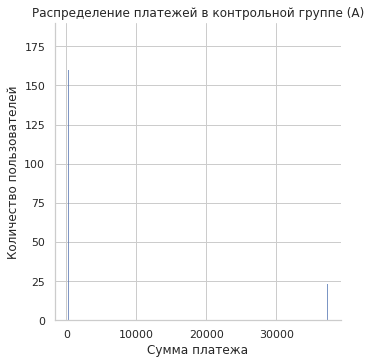

In [55]:
# Распределение платежей в контрольной группе (A)
sns.displot(payments_a, kde=False)

plt.title('Распределение платежей в контрольной группе (A)')
plt.xlabel('Сумма платежа')
plt.ylabel('Количество пользователей')
plt.show()


In [56]:
# Детальный анализ контрольной группы (A)

high_payments = round(
    payments_a[payments_a > 35000].count() / payments_a.count() * 100, 1
)
low_payments = round(
    payments_a[payments_a < 5000].count() / payments_a.count() * 100, 1
)

# Вывод результатов анализа
print(f"""Процент клиентов, заплативших менее 5000 д.е.: {low_payments}%
Процент клиентов, заплативших более 35000 д.е.: {high_payments}%

Средняя сумма платежа у клиентов с низким чеком: {round(payments_a[payments_a < 35000].mean())} д.е.
Средняя сумма платежа у клиентов с высоким чеком: {round(payments_a[payments_a > 35000].mean())} д.е.
""")


Процент клиентов, заплативших менее 5000 д.е.: 93.6%
Процент клиентов, заплативших более 35000 д.е.: 6.4%

Средняя сумма платежа у клиентов с низким чеком: 302 д.е.
Средняя сумма платежа у клиентов с высоким чеком: 37319 д.е.



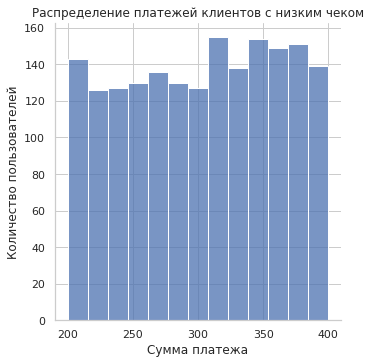

In [57]:
# Посмотрим на распределение платежей клиентов с низким чеком
sns.displot(payments_a[payments_a < 5000], kde=False)

plt.title('Распределение платежей клиентов с низким чеком')
plt.xlabel('Сумма платежа')
plt.ylabel('Количество пользователей')
plt.show()



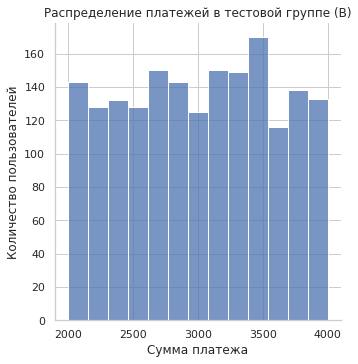

In [58]:
# Распределение платежей в тестовой группе (B)
sns.displot(payments_b, kde=False)

plt.title('Распределение платежей в тестовой группе (B)')
plt.xlabel('Сумма платежа')
plt.ylabel('Количество пользователей')
plt.show()


**Вывод:**

В группе А наблюдается значительная доля клиентов, которые сильно отличаются от общего распределения. 

В группе В распределение более стабильное и постоянное. 

Распределение платежей клиентов с низким чеком в контрольной группе приблизительно совпадает с распределением в тестовой. Не проводя А/В тестирование, на основании двух гистограмм можно сделать вывод, что ARPPU в группе В выше.

Несмотря на это, в данном случае решено применить **t-тест**, хотя использование его может быть некорректным, учитывая влияние платежей клиентов с низким чеком. Это может привести к ошибке 2 рода, если мы примем гипотезу о равенстве групп.

# Тест:

In [59]:
# Выполнение Т-теста
stat, p = ttest_ind(payments_a, payments_b)

# Вывод результатов теста с округлением до 4-х знаков
print(f"""T-test statistic: {round(stat, 4)}
P-value: {round(p, 4)}""")


T-test statistic: -1.5917
P-value: 0.1115


**Вывод:**

Нулевая гипотеза не отклоняется, поскольку P-значение превышает уровень значимости (0.1115 > 0,05), что свидетельствует об отсутствии статистически значимых различий между двумя группами.



# ARPU (Average Revenue Per User)

**Предлагаем следующие гипотезы:**

**H0**: Статистически значимых различий показателя ARPU между двумя группами нет.

**H1**: Показатель ARPU в двух группах отличается.

**Уровень значимости установлен на уровне** 0,05.

**Посмотрим на форму распределения**

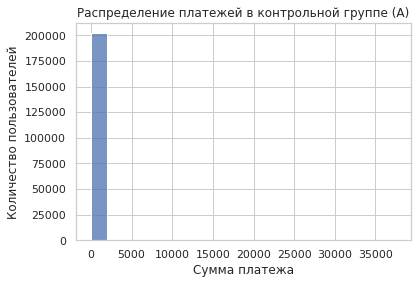

In [60]:
# Распределение платежей в контрольной группе (A)
sns.histplot(group_a.revenue)

plt.title('Распределение платежей в контрольной группе (A)')
plt.xlabel('Сумма платежа')
plt.ylabel('Количество пользователей')
plt.show()


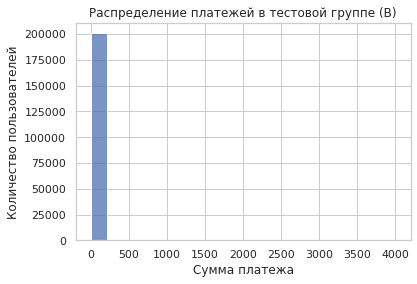

In [61]:
# Распределение платежей в тестовой группе (B)
sns.histplot(group_b.revenue)

plt.title('Распределение платежей в тестовой группе (B)')
plt.xlabel('Сумма платежа')
plt.ylabel('Количество пользователей')
plt.show()

**В данном случае визуализация малоинформативна**

In [62]:
df.groupby('testgroup').agg({'revenue': ['max']})

,revenue
,max
testgroup,
a,37433
b,4000


Выборки имеют значительные отклонения от нормальности. Несмотря на возможное пренебрежение неравенством дисперсий благодаря размеру и схожести выборок, для обеспечения дополнительной надежности используем поправку Уэлча при применении t-критерия.

# Тест:

In [63]:
# Выполнение Т-теста
stat, p = ttest_ind(group_a.revenue, group_b.revenue)

# Вывод результатов теста с округлением до 4-х знаков
print(f"""T-test statistic: {round(stat, 4)}
P-value: {round(p, 4)}""")

T-test statistic: -0.6242
P-value: 0.5325


**Вывод:**

Нулевая гипотеза не отклоняется, поскольку P-значение превышает уровень значимости (0.5325 > 0,05). Таким образом, мы не можем утверждать о наличии статистически значимых различий в показателе ARPU между двумя группами.


# Общие выводы по анализу метрик

**Конверсии в двух группах имеют статистически значимые различия: в группе В конверсия ниже, чем в группе А (в группе А — 0,95%, в группе В — 0,89%). Однако статистически значимых различий в показателе ARPU между группами не выявлено, хотя ARPU в тестовой группе на 5% выше, чем в контрольной (в группе А — 25,41 д.е., в группе В — 26,75 д.е.).**


**Анализ показал, что в контрольной группе платящие пользователи разделились на две подгруппы: у первой подгруппы (93,6% платящих клиентов) средний чек составил 302 д.е., а у второй (6,4%) — 37 319 д.е. Это свидетельствует о том, что набор предложений А оказал влияние на категорию очень платежеспособных клиентов.**


**Если исключить из анализа очень платежеспособных клиентов в группе А, становится очевидным, что средний чек среди обычных платящих пользователей в группе В примерно в 10 раз больше, чем в группе А (группа А — 302 д.е., группа В — 3004 д.е.).**


**Таким образом, на основании текущих данных невозможно однозначно определить, какой набор предложений является наиболее эффективным. Необходим дополнительный анализ воздействия различных наборов предложений на различные сегменты покупателей в зависимости от их среднего чека. Возможно, разные сегменты пользователей будут воспринимать различные наборы акций по-разному.**

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#  Метрики для оценки результатов события

**Для оценки результатов последнего события в игре Plants & Gardens можно применить следующие метрики:**

**Метрики продукта**


1) Daily Active Users (DAU) / Weekly Active Users (WAU) — количество активных пользователей за день / неделю.


2) Среднее время прохождения — время, которое игроки тратят на завершение всех уровней события. Этот показатель помогает оценить эффективность выполнения заданий игроками.


3) Процент завершения события — доля игроков, успешно завершивших все уровни события. Этот показатель позволяет оценить сложность уровней и уровень вовлеченности игроков.

4) Среднее время прохождения одного уровня.


5) Обратная связь от пользователей — опросы или отзывы, собранные после завершения события, предоставляют ценную информацию о восприятии игроками сложности и привлекательности событий.


6) Retention rate


**Метрики роста бизнеса**

1) Выручка — общая сумма денежных средств, полученная от продажи платных доступов.


2 ) CR (конверсия в платящего клиента) — процент участников события, оформивших платный доступ.


3) ARPU (средний доход на одного клиента).


4) ARPPU (средний доход на одного платящего клиента).


5) Кол-во клиентов — общее количество игроков, принявших участвие в игровом событии.


# Изменения в метриках при усложнении механики

В случае усложнения механики события, предполагающего откат игрока на несколько уровней назад после каждой неудачной попытки, перечень предложенных метрик для оценки результатов останется неизменным. Изменения могут затронуть лишь количественные значения соответствующих показателей. 

Вместе с тем, при необходимости, в анализ можно дополнительно включить ситуативные метрики, такие как, например, **среднее количество откатов** - показатель, отражающий среднее число уровней, на которые игроки возвращаются после неудачной попытки. Эта метрика позволяет оценить степень влияния усложнённой механики на игровой процесс.